# Single Node

This code produces all the computations and plots for the first, easy-to-follow application example: The single-node dynamical system.

It is in notebook form to make it more readable.

## Packages

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math

In [ ]:
# check python version
from platform import python_version
python_version()

'3.9.16'

## Definitions

In [2]:
# chosen parameter values of the single-node-system
alpha = 0.1
P = 1
K = 8
theta_ref = 0

In [3]:
# function that adds two angles and returns the result within the range from -pi to pi
def angle_step(a, da):
    return math.remainder(a+da, math.tau)-a

In [4]:
# function that computes the time evolution of the single-node system
def dxdt(t, x):
    theta, omega = x
    return [omega, -alpha*omega +P -K*np.sin(theta-theta_ref)]

In [5]:
# location of the attractor of the system (which represent synchronicity with the grid)
theta_s = np.arcsin(P/K)
omega_s = 0

In [6]:
# function that performs the time evolution from a given initial state and for a given time horizon
def transient(theta_0, omega_0, T):
    sol = solve_ivp(fun=dxdt, t_span=[0,T], y0=[theta_0, omega_0])
    return {"t": sol.t, "omega":sol.y[1], "theta": [math.remainder(a, math.tau) for a in sol.y[0]]}

transient = np.vectorize(transient)

In [7]:
# function that computes the sustainant as defined in the paper
def sustainant(transient):
    return 0.5*(1+np.cos(transient["theta"]-theta_s))*np.exp(-1/20*(transient["omega"]-omega_s)**2)

sustainant = np.vectorize(sustainant)

In [8]:
# function that computes the sustainant deficit based od the minimum acceptable sustainant

S_star = 0.99

def deficit(transient):
    return [ np.max([0, S_star-S]) for S in sustainant(transient)]

deficit = np.vectorize(deficit)

In [9]:
# function that assesses whether a trajectory exceeds a given cost limit
L = 50

def assess(transient):
    d = deficit(transient)
    return np.nan if any(d[-10:-1]!=0) else np.sum(np.diff(transient["t"])*d[:-1])

assess = np.vectorize(assess)

In [10]:
# define the grid in state space to be assessed in terms of resilience
res = 200
theta_0_range = np.linspace(start=-np.pi, stop=np.pi, num=res) + theta_s
omega_0_range = np.linspace(start=-10, stop=10, num=res) + omega_s

theta_grid, omega_grid = np.meshgrid(theta_0_range, omega_0_range)
theta_grid_, omega_grid_ = theta_grid.flatten(), omega_grid.flatten()

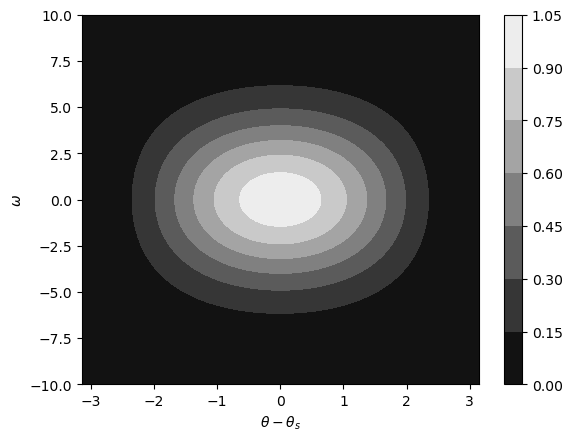

In [11]:
# define the probability density over the state space
sus_grid = (0.5*(1+np.cos(theta_grid_-theta_s))*np.exp(-0.05*omega_grid_**2)).reshape(theta_grid.shape)
plt.contourf(theta_grid-theta_s, omega_grid, sus_grid, cmap="binary_r")
plt.colorbar()
plt.xlabel("$\\theta-\\theta_s$")
plt.ylabel("$\omega$")
plt.show()

## Results

In [12]:
# compute the costs of all trajectories as a grid
T = 120
cost_grid = assess(transient(theta_grid_, omega_grid_, T)).reshape(theta_grid.shape)

In [36]:
# export the grid as a local file for asynchronous data analysis
np.save("cost_grid", cost_grid)

In [37]:
# load the local file
cost_grid = np.load("cost_grid.npy")

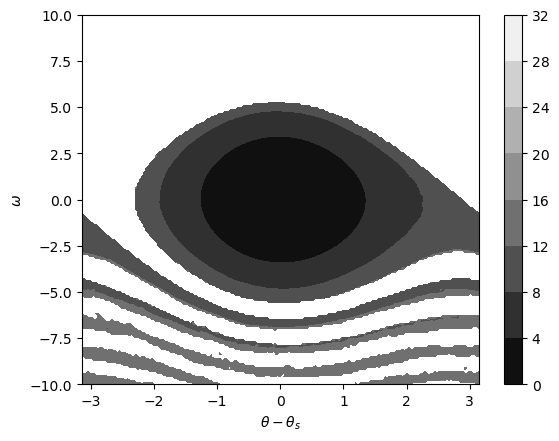

In [38]:
# plot the cost grid

plt.contourf(theta_grid-theta_s, omega_grid, cost_grid, cmap="binary_r")
plt.colorbar()
plt.xlabel("$\\theta-\\theta_s$")
plt.ylabel("$\omega$")
plt.show()

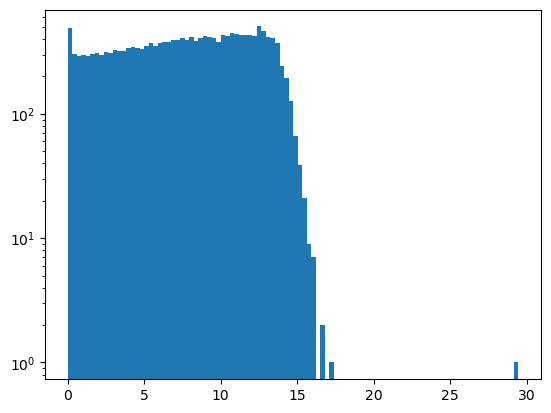

In [46]:
# plot a histogram of the cost distribution to choose a sensible limit
plt.hist(cost_grid.flatten(), bins=100)
plt.semilogy()
plt.show()

In [60]:
# compute the resilience basin grid
L = 12
a = cost_grid < L
basin_grid = np.where(np.isnan(a), 0, a)

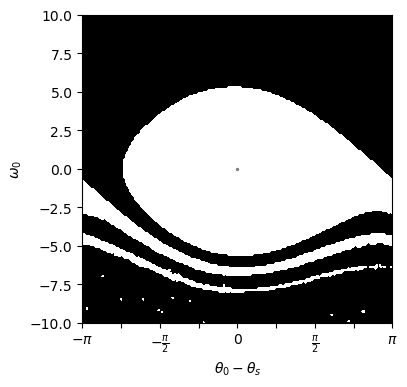

In [78]:
# plot the resilience basin
plt.figure(figsize=(4,4))
plt.contourf(theta_grid-theta_s, omega_grid, basin_grid, levels=1, colors=["k", "w"])
plt.scatter(x=0, y=0, c="grey", s=2)
#plt.colorbar()
plt.xlabel("$\\theta_0-\\theta_s$")
plt.xticks(np.linspace(-np.pi, np.pi, num=9), ["$-\pi$", "", "$-\\frac{\pi}{2}$", "", "0", "", "$\\frac{\pi}{2}$", "", "$\pi$"])
plt.ylabel("$\omega_0$")
#plt.show()

plt.savefig("figure4.pdf", bbox_inches="tight")

In [61]:
# compute the resilience value
basin_grid.sum()*(2*np.pi*20/res**2)

47.31238536306229

In [62]:
# calculate area of the space of initial conditions defined earlier
# this is the maximum achievable size of the resilience basin
(2*np.pi*20)

125.66370614359172